# Introduction to the Finite Element Method

In this notebook we give an introduction to the finite element method and their computer programming, taking advantage of the FEniCS library. 
With this notebook you can acquire the following competences:
* The basics of the FEM
* Ideas of abstractions of the data structures and methods needed to in finite element method
* An introduction to FEniCS, that will be used in the rest of the course
* Write an elemental solver for the 1d traction problem of a linear elastic bar

In [1]:
%matplotlib inline
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt

## Mesh

Let us a create a 1d mesh, of length 1, with uniform element size

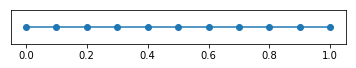

In [2]:
mesh = df.UnitIntervalMesh(10)
df.plot(mesh)

The basic model for the mesh is a collection of two arrays, one with the coordinates of the nodes and one with the node number in each cell. This is what can easily get in FEniCS.
In FEniCS a mesh is class with a set of attributes and methods. 

In [3]:
print("nodes = ", mesh.coordinates())
print("elements = ", mesh.cells())

nodes =  [[0. ]
 [0.1]
 [0.2]
 [0.3]
 [0.4]
 [0.5]
 [0.6]
 [0.7]
 [0.8]
 [0.9]
 [1. ]]
elements =  [[ 0  1]
 [ 1  2]
 [ 2  3]
 [ 3  4]
 [ 4  5]
 [ 5  6]
 [ 6  7]
 [ 7  8]
 [ 8  9]
 [ 9 10]]


## Finite Element Discrete Function Space

The basic ideas of FE is to approximate the solutions of ODE and PDE by using a Ritz-Galerking approximation.
Solutions are approximated by a linear combination of $n$ basis functions $\varphi_i$
$$ u(x) = \sum_{i=1}^n \varphi_i(x) U_i$$
i.e. in the discrete function space
$$
V = \mathrm{span}\{\varphi_1,\ldots,\varphi_n\} 
$$
The finite element method is a system method to define the basis function in a way which is indipendent of the shape of the domain. The basic idea is to have this function defined "elementwise". 

We can create in FEniCS a finite element function space with the following command. 

In [7]:
V = df.FunctionSpace(mesh,"P",1)

We should specify the mesh,  the type of interpolation functions (`P` is for Lagrange polynomials), and the order (`1` stays for linear polynomials). 
The function space is an important object (a python class here), that collect the basis function and also the information on the mapping between globel degree of freedom and cell number (`dofmap`). This gives for examples the `dof` of the cell `2`. 

In [ ]:
V

In [8]:
dofmap = V.dofmap()
dofmap.cell_dofs(2)

array([8, 7], dtype=int32)

## Functions 
In a finite element element function space a function is caracterized by the a n-dimensional vector collecting the coefficients $U_i$. We can define a function as follows in FEniCS (and give it a name)

In [11]:
u = df.Function(V, name = "displacement")

We can access the vector of the $U_i$ as follows and convert it to a numpy array. Note that it is always initialized to 0.

In [12]:
u_vec = u.vector()
print(u_vec.get_local())

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


For `P1`spaces, we can easily set the value of the `U_i`'s to approximate an analytical expression `f` by interpolation, i.e. setting $U_i=f(x_i)$. 

In [19]:
4**2

16

In [24]:
f = df.Expression('sin(5*pow(x[0],2))', degree = 2)
u.interpolate(f)
u_vec.get_local()

array([-0.95892427, -0.78852525, -0.05837414,  0.6377647 ,  0.97384763,
        0.94898462,  0.71735609,  0.43496553,  0.19866933,  0.04997917,
        0.        ])

We can plot a function by using a built-in plot function in FEniCS:

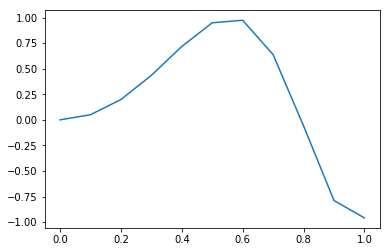

In [25]:
df.plot(u)

or by using matplotlib:

In [26]:
mesh.coordinates()[:,0]

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [27]:
V.tabulate_dof_coordinates()

array([[1. ],
       [0.9],
       [0.8],
       [0.7],
       [0.6],
       [0.5],
       [0.4],
       [0.3],
       [0.2],
       [0.1],
       [0. ]])

Text(0,0.5,'u')

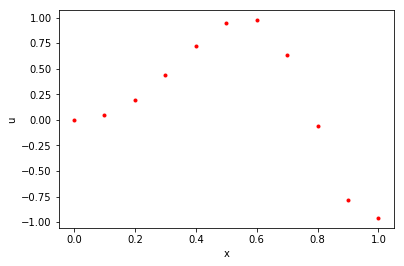

In [28]:
import matplotlib.pyplot as plt 
plt.plot(mesh.coordinates()[:,0], u.compute_vertex_values(),"r.")
plt.xlabel("x")
plt.ylabel("u")

You can write the function to a file either in speficif format, that can be read by `paraview`

In [ ]:
with df.XDMFFile(mesh.mpi_comm(), "output/bar.xdmf") as file: 
    file.write(u)

Or as a text (only for small things ...)

In [ ]:
np.savetxt('output/bar.txt',  u_vec.get_local(), fmt='%.2e')

## Variational formulation 
Let us consider the problem of the traction of a bar of length $L$, axial stiffness $ES(x)$, blocked in $x=0$ and subjected to an end force $P$ and a distributed load $f(x)$. The variational formulation of the problem is:

Find a *trial function* $u\in V$ such that for each *test function* in $v\in V$: 
$$
a(u,v) = l(v)
$$
where for our bar
$$a(u,v)=\int_0^L ES(x)\, u'(x)\,v'(x) \mathrm{d}x, \quad \ell(v)=P\,u(L)+\int_0^L f(x)\,v(x) \mathrm{d}x$$
From that one should 

1. Assemble the stiffness matrix $A$ and load vector $b$ defined by
    $$
    A_{ij}=a(\varphi_i,\varphi_j),\qquad b_j=\ell(\varphi_j)
    $$
2. Impose the Dirichlet boundary condition at the discrete level
3. Solve the linear system 
    $$A U=b$$

## Assembling

The first step is often the most tedius and technical one when writing a FE code, even if conceptually is very simple.
Indeed, it can be completely automasize. Many modern FE libraries implement automatic code generator that write the assembling routing given the bilinear form $a$ and the linear form $\ell$. 

A component of FEniCS, `UFL` (Unified form language) provides a syntax to straightforwardly and efficiently write variational form link on paper, taking also advantage of symbolic calculus. Below how to write this variational problem in `UFL`

In [29]:
ES = df.Expression('k', k=1., degree = 2)
f = df.Expression('sin(x[0])', degree = 2)
P = df.Constant("1.")
u_ = df.TrialFunction(V)
v = df.TestFunction(V)
dx = df.dx # Volume measure
ds = df.ds # surface measure
a = (u_.dx(0)*v.dx(0))*dx
l = f*v*dx+P*v*ds

Hence one can take advantage of automatic code generation to assemble the system with efficient `C++` code. When evaluating the lines below for the first time, FEniCS do the following 
1. automatically generate an highly optimized `C++` codes to assemble A and b;
2. compile them on the flight (JIT, Just In Time compilation);
3. Call in python the resulting executable and assemble the matrix. 

Steps 1-2 can require some time (of the order of seconds), but are executed only once. When repeating the assembling for the same form, the executable are reused. The time required to generate and compile the code are indipendent of the number of `dof`. It can appear long for very small system, like the present one (say 1 second), but are completely negligible when solving large problem where most of the timing is spent in solving the linear system. 

In [30]:
A = df.assemble(a)
b = df.assemble(l)

With this no more need to write tedius assembling routines! YOu can access the entries of the matrices as below (viewing them as `numpy` arrays)

In [31]:
A.array()

array([[ 10., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  10.]])

In [32]:
b.get_local()

array([1.04113837, 0.07826743, 0.07167584, 0.0643681 , 0.0564172 ,
       0.04790261, 0.03890939, 0.0295274 , 0.01985038, 0.00997502,
       1.00166597])

## Dirichlet Boundary Conditions

The formulation above does not yet accout for the dirichlet boundary condition $u=0$ in $x=0$.
The Dirichlet BCs are usually imposed in the finite element formulation at the discrete level, by suitably hacking the linear system to solve (deleting or modifying raws and/or columns of $A$ and $b$). 

In fenics this is done with the `DirichletBC`. This introduces an object instrumental to impose the value `0.` on the space `V` in the *subdomain* `x[0]==0`.

In [37]:
bc = df.DirichletBC(V,2.,"x[0]==0")

### Method 1 (`bc.apply`, A not sym)

A first method to abbly the boundary condition is the following

In [38]:
bc.apply(A)
bc.apply(b)

The stiffness matrix and load vector are modified to satisfy the desired conditions when solving the linear system (try to understad what is done as an exercice)

In [39]:
A.array()

array([[ 10., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]])

In [40]:
b.get_local()

array([1.04113837, 0.07826743, 0.07167584, 0.0643681 , 0.0564172 ,
       0.04790261, 0.03890939, 0.0295274 , 0.01985038, 0.00997502,
       1.53      ])

### Method 2 (`assemble_system`, A sym)

This is an alternative that preserves the symmetry of the A matrix. 
Guess what is the method!

In [41]:
A,b = df.assemble_system(a,l,bc)

In [42]:
A.array()

array([[ 10., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [-10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20., -10.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,  20.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]])

In [43]:
b.get_local()

array([ 1.04113837,  0.07826743,  0.07167584,  0.0643681 ,  0.0564172 ,
        0.04790261,  0.03890939,  0.0295274 ,  0.01985038, 15.30997502,
        1.53      ])

## Solve the linear system

The solution of the linear system is often the most time-consuming part of the running time of a finite element solver. In finite element one never computes explicity the inverse of the matrix `A` but uses appropiate *direct* or *iterative* solvers. This because computing the inverse of `A` is feasible only for very small matrices. Even if `A` is sparse (tridiagonal here), its inverse is generally full.

The matrix A is saved in RAM (and not to disk) in a sparse format.
Several format are used. All the linear algebra part is very often managed though specialised library. This becomes very important when one want an efficient parallel implementation. The reference library for linear algebra in HPC is nowadays [PETSc](http://www.mcs.anl.gov/petsc/). 

We will solve below the linear system by the default *direct* linear solve, and put the solution vector in the coefficient of the function $u$. More details on the solvers will be given in dedicated notebook.

In [45]:
df.linear_solver_methods()

{'bicgstab': 'Biconjugate gradient stabilized method',
 'cg': 'Conjugate gradient method',
 'default': 'default linear solver',
 'gmres': 'Generalized minimal residual method',
 'minres': 'Minimal residual method',
 'mumps': 'MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)',
 'petsc': 'PETSc built in LU solver',
 'richardson': 'Richardson method',
 'superlu': 'SuperLU',
 'superlu_dist': 'Parallel SuperLU',
 'tfqmr': 'Transpose-free quasi-minimal residual method',
 'umfpack': 'UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)'}

In [52]:
df.list_krylov_solver_preconditioners()

In [53]:
df.solve(A,u.vector(),b,"cg", "ilu")


1

## Post-processing

We can easily plot the result for the displacement

(0, 6)

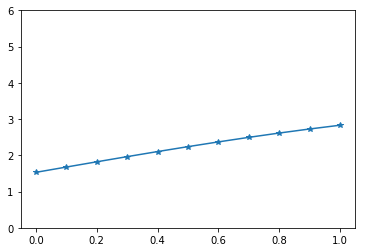

In [55]:
df.plot(u, marker= "*")
plt.ylim([0,6])

## Refactoring as a function 

For parametric analysis, it may be useful to refactor the code as a function returning the finite element solution

In [56]:
%matplotlib inline
import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

def bar_solver(Pv,n,p):
    mesh = fe.UnitIntervalMesh(n)
    V = fe.FunctionSpace(mesh,"P",p)
    u_ = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    u = fe.Function(V)
    ES = fe.Expression('k', k=1., degree=2)
    f = fe.Expression('sin(x[0])', degree=2)
    P = fe.Expression("P",P=Pv,degree=0)
    a = (u_.dx(0)*v.dx(0))*fe.dx
    l = f*v*fe.dx+P*v*fe.ds
    bc = fe.DirichletBC(V,0.,"x[0]==0")
    A,b = fe.assemble_system(a,l,bc)
    fe.solve(A,u.vector(),b)
    return u

with df.XDMFFile(mesh.mpi_comm(), "output/bar.xdmf") as file: 
    file.write(u)

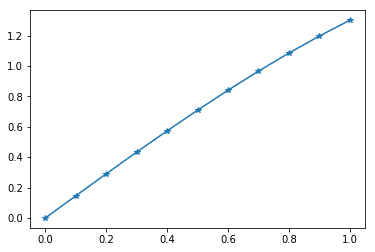

In [57]:
u = bar_solver(P,10,1)
fe.plot(u,marker="*",label=P)

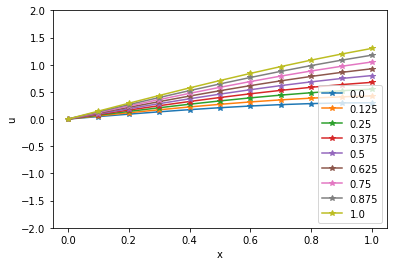

In [58]:
for P in np.linspace(0,1,9):
    u = bar_solver(P,10,1)
    fe.plot(u,marker="*",label=P)
    plt.ylim([-2,2])
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

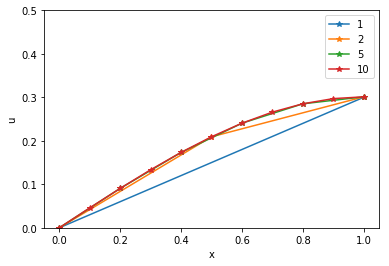

In [59]:
for n in [1,2,5,10]:
    u = bar_solver(0,n,1)
    fe.plot(u,marker="*",label=n)
    plt.ylim([0,.5])
plt.xlabel("x")
plt.ylabel("u")
plt.legend()